# Bean Leaf Classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import evaluate
import torch

from datasets import load_dataset
from transformers import TrainingArguments
from transformers import Trainer
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [2]:
dataset = load_dataset("beans")

Using custom data configuration default
Reusing dataset beans (C:\Users\Teuku Rizky\.cache\huggingface\datasets\beans\default\0.0.0\90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
print(dataset["train"])

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 1034
})


We have 1034 training samples

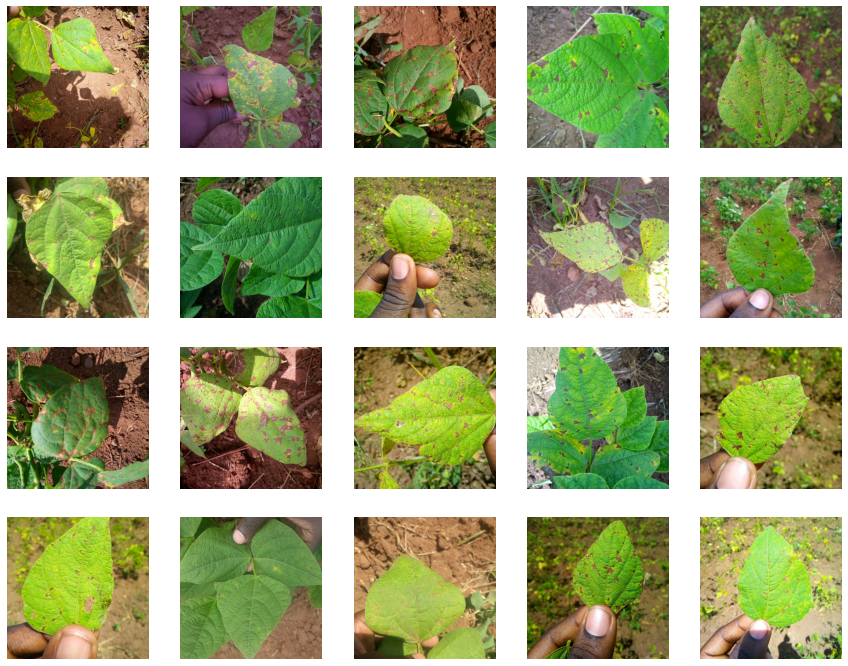

In [4]:
fig=plt.figure(figsize=(15, 12))
for i in range(0, 20):
  fig.add_subplot(4, 5, i + 1)
  plt.imshow(dataset["train"][i]["image"])
  plt.axis('off')
plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
#model.eval()
#model.to(device);

In [6]:
type(model)

transformers.models.vit.modeling_vit.ViTForImageClassification

In [7]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

In [8]:
# First we get the features corresponding to the first training image
encoding = feature_extractor(images=dataset['train'][1]['image'], return_tensors="pt")

In [9]:
with torch.no_grad():
    logits = model(**encoding).logits

In [10]:
prediction = logits.argmax(-1).item()

print("Predicted class:", model.config.id2label[prediction])

Predicted class: ear, spike, capitulum


In [11]:
def transform(example_batch):
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = dataset.with_transform(transform)

In [12]:
metric = evaluate.load("accuracy")

def compute_metrics(sample):
    return metric.compute(
        predictions=np.argmax(sample.predictions, axis=1), 
        references=sample.label_ids)

In [13]:
training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

Using amp half precision backend


In [14]:
# train_results = trainer.train()
# trainer.save_model("my_model")
# trainer.log_metrics("train", train_results.metrics)
# trainer.save_metrics("train", train_results.metrics)
# trainer.save_state()

In [15]:
# eval_accuracy = trainer.evaluate()

In [16]:
# eval_accuracy

In [17]:
# test_accuracy = trainer.predict(prepared_ds["test"])

In [18]:
# test_accuracy.metrics

In [19]:
fine_tuned = ViTForImageClassification.from_pretrained("vit-base-beans/checkpoint-200");
fine_tuned.to(device)

loading configuration file vit-base-beans/checkpoint-200\config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linnet, Carpodacus mexicanus",
    "13": "junco, snowbird",
    "14": "indigo bunting, indigo finch, indigo bird, Passerina cyanea",
    "15": "robin, 

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [20]:
labels = dataset['train'].features['labels'].names

def classify(im):
  features = feature_extractor(im, return_tensors='pt').to(device)
  logits = fine_tuned(features["pixel_values"])[-1]
  probability = torch.nn.functional.softmax(logits, dim=-1)
  probs = probability[0].detach().cpu().numpy()
  confidences = {label: float(probs[i]) for i, label in enumerate(labels)} 
  return confidences

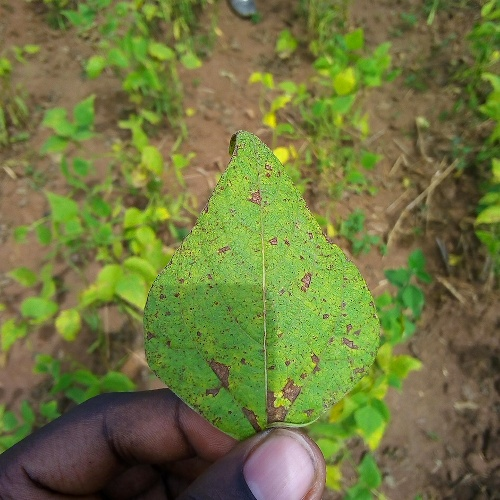

In [26]:
im = dataset["test"][1]["image"]
im

In [27]:
predict = classify(im)
predict

{'angular_leaf_spot': 0.9998714923858643,
 'bean_rust': 4.5179964217823e-05,
 'healthy': 2.7013484782401065e-07}

In [24]:
import gradio as gr

interface = gr.Interface(
    fn=classify, 
    inputs="image", 
    outputs=gr.Label(num_top_classes=3),
    examples=["ex1.png", "ex2.png"])

interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://46472.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x26e2ec4ed60>,
 'http://127.0.0.1:7860/',
 'https://46472.gradio.app')